In [11]:
import glob
import os
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [12]:
pattern = os.path.join("..", "data", "top10","*")
files = glob.glob(pattern)

In [13]:
cur_dic = {}
for file in files:
    key = os.path.basename(file).split("-")[0]
    cur_dic[key] = pd.read_csv(file, index_col=["snapped_at"], parse_dates=["snapped_at"])
print(cur_dic.keys())

dict_keys(['eth', 'xrp', 'usdt', 'eos', 'bnb', 'bch', 'bsv', 'ltc', 'ada', 'btc'])


In [14]:
cur_dic["xrp"].head()

,price,market_cap,total_volume
snapped_at,,,
2013-08-04,0.535026,4.182777e+09,0.0
2013-08-05,0.508189,3.972964e+09,0.0
2013-08-06,0.421078,3.291944e+09,0.0
2013-08-07,0.401962,3.142494e+09,0.0
2013-08-08,0.377348,2.950063e+09,0.0


In [15]:
cur_dic["btc"].index

DatetimeIndex(['2013-04-28 00:00:00', '2013-04-29 00:00:00',
               '2013-04-30 00:00:00', '2013-05-01 00:00:00',
               '2013-05-02 00:00:00', '2013-05-03 00:00:00',
               '2013-05-04 00:00:00', '2013-05-05 00:00:00',
               '2013-05-06 00:00:00', '2013-05-07 00:00:00',
               ...
               '2019-12-25 00:00:00', '2019-12-26 00:00:00',
               '2019-12-27 00:00:00', '2019-12-28 00:00:00',
               '2019-12-29 00:00:00', '2019-12-30 00:00:00',
               '2019-12-31 00:00:00', '2020-01-01 00:00:00',
               '2020-01-02 00:00:00', '2020-01-03 00:00:00'],
              dtype='datetime64[ns]', name='snapped_at', length=2440, freq=None)

In [16]:
date_key = pd.date_range(start='2013-01-01 00:00:00', end='2020-01-03 00:00:00', freq='D')
print(date_key)
price_df = pd.DataFrame(index=date_key)
market_cap = pd.DataFrame(index=date_key)
total_volume = pd.DataFrame(index=date_key)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30', '2019-12-31', '2020-01-01',
               '2020-01-02', '2020-01-03'],
              dtype='datetime64[ns]', length=2559, freq='D')


In [17]:
for key, val in cur_dic.items():
    price_df[key] = val["price"]
    market_cap[key] = val["market_cap"]
    total_volume[key] = val["total_volume"]

In [18]:
def fill(df):
#     df.interpolate(inplace=True)
#     df.fillna(0, inplace=True)
    rdf = df.dropna(how='all')
    return rdf

In [19]:
# 1日ごとの差分を求める
def get_diff(df):
    df = df.diff()
    df.dropna(how='all', inplace=True)
    return df

In [20]:
# 期間の指定
def designate_dur(df, start, end):
    rdf = df.reset_index()
    rdf = rdf[(rdf["index"] >= start) & (rdf["index"] <= end)]
    rdf.set_index("index", inplace=True, drop=True)
    return rdf

In [21]:
def from_adj_to_edge(df):
    li = df.values.tolist()
    label = df.index.tolist()
    from_l = []
    to_l = []
    w_l = []
    for i in range(len(li)):
        for j in range(i + 1, len(li)):
            from_l.append(label[i])
            to_l.append(label[j])
            w_l.append(li[i][j])
    rdf = pd.DataFrame()
    rdf["from"] = from_l
    rdf["to"] = to_l
    rdf["weight"] = w_l
    return rdf

In [22]:
price_df = fill(price_df)
market_cap = fill(market_cap)
total_volume = fill(total_volume)

In [23]:
start = pd.to_datetime('2019-03-30')
end = pd.to_datetime('2019-06-30')
price_dur_df = designate_dur(price_df, start, end)

In [24]:
scaler = MinMaxScaler()
scaled_price_df = pd.DataFrame(scaler.fit_transform(price_dur_df), columns=price_dur_df.columns, index=price_dur_df.index)

In [25]:
scaled_price_df.head()

,eth,xrp,usdt,eos,bnb,bch,bsv,ltc,ada,btc
index,,,,,,,,,,
2019-03-30,0.007911,0.095941,0.650343,0.037175,0.000000,0.011218,0.068457,0.012819,0.318255,0.000000
2019-03-31,0.003306,0.114089,0.645711,0.000000,0.016052,0.000000,0.071646,0.000000,0.315431,0.000063
2019-04-01,0.000000,0.105408,0.646759,0.012563,0.042830,0.006636,0.071549,0.001858,0.262953,0.000323
2019-04-02,0.003026,0.135073,0.744939,0.019451,0.070490,0.004670,0.078832,0.004912,0.341550,0.007530
2019-04-03,0.123720,0.364676,0.783103,0.214018,0.156595,0.247794,0.151163,0.219866,0.702197,0.091283


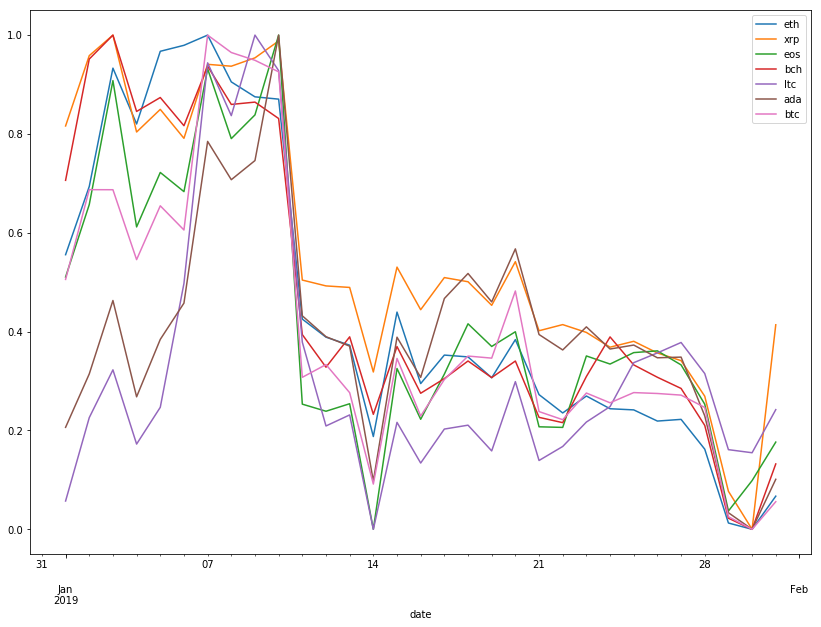

In [60]:
scaled_price_df.index.name = "date"
scaled_price_df[['eth', 'xrp',  'eos', 'bch', 'ltc', 'ada', 'btc']].plot(figsize=(14, 10))

In [61]:
price_dur_df.head()

,eth,xrp,usdt,eos,bnb,bch,bsv,ltc,ada,btc
date,,,,,,,,,,
2019-01-01,14412.437498,38.281468,110.073415,276.668182,666.821104,16318.068440,9196.978498,3273.742179,4.444281,404829.580826
2019-01-02,15149.615198,39.489044,110.973342,286.960747,656.591571,17814.720091,9940.767610,3446.191122,4.596076,416097.040820
2019-01-03,16429.053067,39.841685,108.729163,304.588174,651.006719,18109.959160,10012.961840,3545.073229,4.804865,416090.070314
2019-01-04,15825.508700,38.177657,108.129482,283.787852,625.619374,17167.893871,9401.161026,3391.541708,4.531020,407314.099827
2019-01-05,16611.229209,38.566376,109.552060,291.530125,647.607336,17339.888073,9401.801987,3467.581275,4.694304,414071.044710


In [62]:
diff_price = get_diff(price_dur_df)
diff_price = diff_price.dropna(how='all', axis=1)

In [63]:
autocorrs = [diff_price["btc"].autocorr(lag=i) for i in range(60)]
print("max: {}, index: {}".format(np.max(autocorrs[1:]), np.argmax(autocorrs[1:])))

max: nan, index: 28


/Users/kerneltyu/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/kerneltyu/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [64]:
diff_price.head()

,eth,xrp,usdt,eos,bnb,bch,bsv,ltc,ada,btc
date,,,,,,,,,,
2019-01-02,737.177699,1.207576,0.899927,10.292565,-10.229533,1496.651651,743.789112,172.448943,0.151794,11267.459994
2019-01-03,1279.437869,0.352641,-2.244180,17.627427,-5.584853,295.239069,72.194230,98.882107,0.208789,-6.970506
2019-01-04,-603.544367,-1.664027,-0.599681,-20.800322,-25.387344,-942.065289,-611.800813,-153.531521,-0.273844,-8775.970487
2019-01-05,785.720509,0.388719,1.422578,7.742272,21.987962,171.994202,0.640960,76.039567,0.163284,6756.944883
2019-01-06,64.594328,-0.497073,-0.387554,-2.725502,-5.780857,-347.994286,42.740617,256.167371,0.103133,-3034.869931


In [65]:
diff_price.corr()

,eth,xrp,usdt,eos,bnb,bch,bsv,ltc,ada,btc
eth,1.000000,0.807611,-0.141064,0.915165,0.623267,0.858420,0.757371,0.781700,0.869509,0.824699
xrp,0.807611,1.000000,-0.014756,0.830767,0.572499,0.873795,0.770325,0.761140,0.840635,0.836464
usdt,-0.141064,-0.014756,1.000000,-0.093944,0.226052,0.028901,-0.015042,-0.014664,-0.067567,0.168814
eos,0.915165,0.830767,-0.093944,1.000000,0.691358,0.893477,0.774836,0.835963,0.947365,0.897345
bnb,0.623267,0.572499,0.226052,0.691358,1.000000,0.612391,0.571600,0.650320,0.677269,0.736181
bch,0.858420,0.873795,0.028901,0.893477,0.612391,1.000000,0.895153,0.822725,0.835014,0.877509
bsv,0.757371,0.770325,-0.015042,0.774836,0.571600,0.895153,1.000000,0.741846,0.728091,0.737599
ltc,0.781700,0.761140,-0.014664,0.835963,0.650320,0.822725,0.741846,1.000000,0.869460,0.880570
ada,0.869509,0.840635,-0.067567,0.947365,0.677269,0.835014,0.728091,0.869460,1.000000,0.900566
btc,0.824699,0.836464,0.168814,0.897345,0.736181,0.877509,0.737599,0.880570,0.900566,1.000000


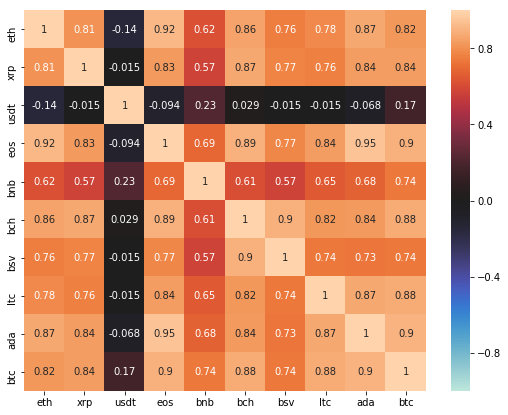

In [66]:
figure = plt.figure(figsize=(9,7))
sns.heatmap(diff_price.corr(), vmax=1, vmin=-1, center=0, annot=True)

In [67]:
def transform_variable(x):
    return np.sqrt(2*(1-x))

In [68]:
# 距離の公理を満たすために変数変換
# x = √(2(1-ρ))
corr_diff_price = diff_price.corr()
tran_corr_diff_price = corr_diff_price.apply(transform_variable)

In [69]:
tran_corr_diff_price

,eth,xrp,usdt,eos,bnb,bch,bsv,ltc,ada,btc
eth,0.000000,0.620305,1.510671,0.411911,0.868024,0.532128,0.696605,0.660757,0.510864,0.592117
xrp,0.620305,0.000000,1.424609,0.581778,0.924663,0.502403,0.677754,0.691172,0.564561,0.571902
usdt,1.510671,1.424609,0.000000,1.479151,1.244144,1.393627,1.424810,1.424545,1.461210,1.289330
eos,0.411911,0.581778,1.479151,0.000000,0.785675,0.461568,0.671066,0.572777,0.324453,0.453111
bnb,0.868024,0.924663,1.244144,0.785675,0.000000,0.880465,0.925635,0.836278,0.803406,0.726386
bch,0.532128,0.502403,1.393627,0.461568,0.880465,0.000000,0.457924,0.595440,0.574432,0.494956
bsv,0.696605,0.677754,1.424810,0.671066,0.925635,0.457924,0.000000,0.718545,0.737440,0.724432
ltc,0.660757,0.691172,1.424545,0.572777,0.836278,0.595440,0.718545,0.000000,0.510959,0.488734
ada,0.510864,0.564561,1.461210,0.324453,0.803406,0.574432,0.737440,0.510959,0.000000,0.445945
btc,0.592117,0.571902,1.289330,0.453111,0.726386,0.494956,0.724432,0.488734,0.445945,0.000000


In [70]:
edge_df = from_adj_to_edge(tran_corr_diff_price)

In [71]:
edge_df.head()

,from,to,weight
0,eth,xrp,0.620305
1,eth,usdt,1.510671
2,eth,eos,0.411911
3,eth,bnb,0.868024
4,eth,bch,0.532128


In [72]:
G = nx.from_pandas_adjacency(tran_corr_diff_price)

# 全域最小木

In [73]:
T = nx.minimum_spanning_tree(G)
print(sorted(T.edges(data=True)))

[('ada', 'btc', {'weight': 0.44594514197674656}), ('bch', 'bsv', {'weight': 0.45792439773953436}), ('bnb', 'btc', {'weight': 0.726386388990059}), ('eos', 'ada', {'weight': 0.32445349873585655}), ('eos', 'bch', {'weight': 0.4615682512794366}), ('eth', 'eos', {'weight': 0.41191112178089617}), ('ltc', 'btc', {'weight': 0.4887337663962295}), ('usdt', 'bnb', {'weight': 1.2441444378561293}), ('xrp', 'bch', {'weight': 0.5024034389586518})]


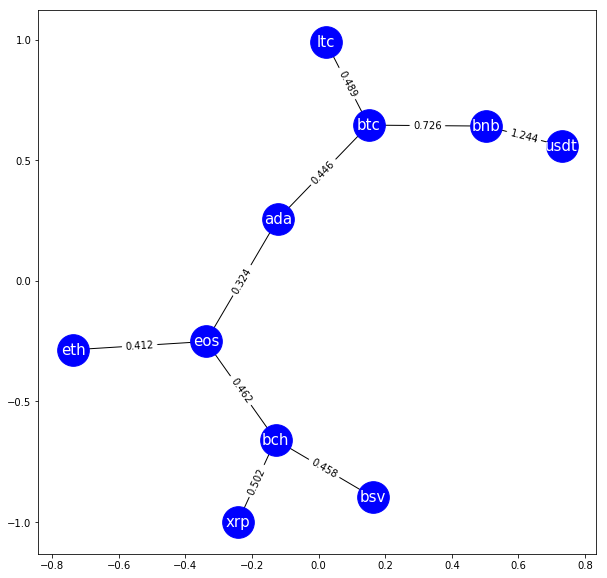

In [74]:
fig = plt.figure(figsize=(10,10))
node_color = ['r' for i in range(G.number_of_nodes())]
edge_labels = {(i, j): round(w["weight"], 3) for i, j, w in T.edges(data=True)}
pos = nx.spring_layout(T, k=0.5) # 
nx.draw_networkx_nodes(T, pos, node_size=1000, node_color="blue")
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(T, pos, font_size=15, font_color="white")
nx.draw_networkx_edges(T, pos)
# nx.draw_networkx(T, pos, with_labels=True, alpha=0.5, node_color=node_color)

# クラスタリング

In [75]:
li = tran_corr_diff_price.values.tolist()
pdist = squareform(li)
label = tran_corr_diff_price.index.tolist()

1.2592169985802508


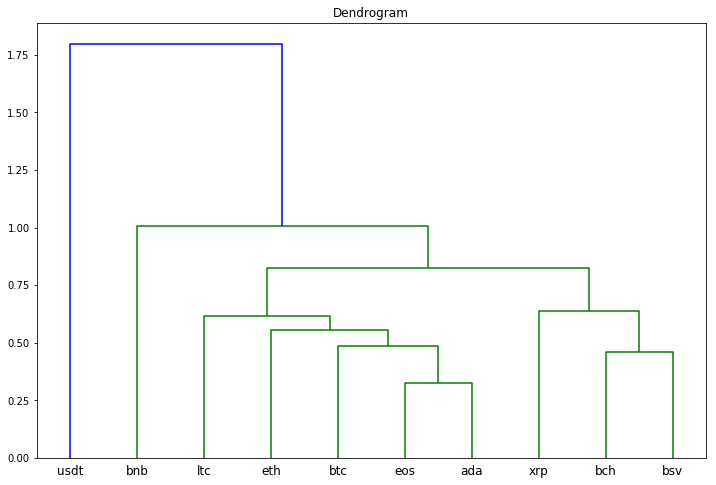

In [76]:
res = linkage(pdist, method='ward')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
dendrogram(res, labels=label, color_threshold=1.4)
plt.title("Dendrogram")
locs, labels = plt.xticks()
print( 0.7 * max(res[:, 2]))

In [77]:
pca = PCA(n_components=7)
x = corr_diff_price.values
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [78]:
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

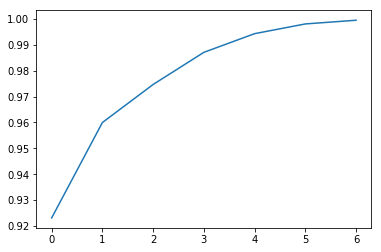

In [79]:
plt.plot(cum_ratio)

In [80]:
print(label)
print(pca.components_)

['eth', 'xrp', 'usdt', 'eos', 'bnb', 'bch', 'bsv', 'ltc', 'ada', 'btc']
[[-0.36846409 -0.31596139  0.37601023 -0.3636372  -0.13670048 -0.31503664
  -0.29477995 -0.3118751  -0.34933119 -0.25818256]
 [-0.01191777 -0.20713128  0.15668011  0.11729224  0.78983408 -0.24311903
  -0.37037166  0.15339006  0.17912593  0.20715684]
 [-0.08480157 -0.13722631 -0.05362107 -0.1229206   0.53016498  0.1781117
   0.6740907  -0.18314908 -0.32553673 -0.22198704]
 [ 0.35657355 -0.23102378 -0.65085307  0.1028447   0.04046915 -0.27810258
  -0.2034318  -0.33710343  0.01992107 -0.38845553]
 [-0.16129818 -0.58920307 -0.2331111  -0.10455959 -0.1754758  -0.11755638
   0.16849775  0.69614968  0.01659995 -0.06038592]
 [-0.43778206  0.60677751 -0.36266233 -0.33211508  0.16002448 -0.27603448
  -0.05594558  0.22999162  0.04198432 -0.19685509]
 [-0.55265251 -0.14655089 -0.00154789  0.37660533 -0.08219225 -0.12553506
   0.24491554 -0.31645148  0.58738297 -0.0600462 ]]


In [28]:
index = pd.date_range('2019-01-01', '2019-12-31', freq="A")

In [29]:
index.tolist()[0]

Timestamp('2019-12-31 00:00:00', freq='A-DEC')